# **Smarter anomaly detection** - Post-processing back-test results
*Part 3 - Results post-processing*

## Initialization
---
This repository is structured as follow:

```sh
. smarter-anomaly-detection
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets ready to be moved to Amazon S3
|   └── raw                              # Immutable original data are stored here
|
└── notebooks/
    ├── 1_data_preparation.ipynb
    ├── 2_model_training.ipynb
    └── 3_model_evaluation.ipynb         <<< THIS NOTEBOOK <<<
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade lookoutequipment

### Imports

In [2]:
import boto3
import synthetic_config as config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker

from matplotlib.gridspec import GridSpec

# SDK / toolbox for managing Lookout for Equipment API calls:
import lookoutequipment as lookout

### Parameters

In [3]:
TMP_DATA       = os.path.join('..', 'data', 'interim')
PROCESSED_DATA = os.path.join('..', 'data', 'processed')
LABEL_DATA     = os.path.join(PROCESSED_DATA, 'label-data')
TRAIN_DATA     = os.path.join(PROCESSED_DATA, 'train-data', 'synthetic')

MODEL_NAME     = config.MODEL_NAME
DATASET_NAME   = config.DATASET_NAME
ROLE_ARN       = sagemaker.get_execution_role()

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['lines.linewidth'] = 1.0

### Loading original datasets for visualization purpose

In [5]:
all_tags_fname = os.path.join(TRAIN_DATA, 'sensors.csv')
all_tags_df = pd.read_csv(all_tags_fname)
all_tags_df['Timestamp'] = pd.to_datetime(all_tags_df['Timestamp'])
all_tags_df = all_tags_df.set_index('Timestamp')

### Helper functions

In [6]:
def plot_ranges(range_df, range_title, color, ax):
    ax.plot(range_df['Label'], color=color)
    ax.fill_between(range_df.index, 
                    y1=range_df['Label'], 
                    y2=0, 
                    alpha=0.1, 
                    color=color)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel(range_title, fontsize=12)

def compute_bin_edges(signals, num_bins=10):
    # Checks if the argument is a nested type or a numeric one:
    if isinstance(signals[0], (int, float)):
        all_signals_min = np.min(signals)
        all_signals_max = np.max(signals)
        
    # For nested type (list of pandas.Series, list of lists...), we
    # need to compute the min and max of each component of the list:
    else:
        all_signals_max = None
        all_signals_min = None
        for s in signals:
            signal_max = np.max(s)
            if (all_signals_max is not None) and (signal_max > all_signals_max):
                all_signals_max = signal_max
            elif all_signals_max is None:
                all_signals_max = signal_max
                
            signal_min = np.min(s)
            if (all_signals_min is not None) and (signal_min < all_signals_min):
                all_signals_min = signal_min
            elif all_signals_min is None:
                all_signals_min = signal_min
        
    # Now we can compute the bin width and their edges:
    bin_width = (all_signals_max - all_signals_min)/num_bins
    bins = np.arange(
        all_signals_min, 
        all_signals_max + bin_width, 
        bin_width
    )
    
    return bins

def plot_histogram_comparison(timeseries_1, 
                              timeseries_2, 
                              ax=None, 
                              label_timeseries_1=None, 
                              label_timeseries_2=None, 
                              show_legend=True,
                              num_bins=10
                             ):
    bins = compute_bin_edges([timeseries_1, timeseries_2], num_bins=num_bins)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    
    ax.hist(timeseries_1, 
            density=True, 
            alpha=0.5, 
            bins=bins, 
            edgecolor='#FFFFFF', 
            color='tab:red', 
            label=label_timeseries_1)
            
    ax.hist(timeseries_2, 
            density=True, 
            alpha=0.5, 
            bins=bins, 
            edgecolor='#FFFFFF', 
            color='tab:blue', 
            label=label_timeseries_2)
    
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    
    if (show_legend) and \
       (label_timeseries_1 is not None) and \
       (label_timeseries_2 is not None):
        ax.legend(framealpha=0.5, fontsize=12)
        
    return ax

def plot_histograms(current_tag, expanded_results, freq='1min', fig_width=6, fig_height=6, start=None, end=None):
    abnormal_index = predictions_df[predictions_df['Label'] > 0.0].index
    normal_index = predictions_df[predictions_df['Label'] == 0.0].index

    if (start is not None) and (end is not None):
        abnormal_index = predictions_df[predictions_df['Label'] > 0.0]
        abnormal_index = abnormal_index.loc[start:end].index
        normal_index = predictions_df[predictions_df['Label'] == 0.0]
        normal_index = normal_index.loc[start:end].index
        expanded_results = expanded_results.loc[start:end]

    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = fig.add_subplot(111)

    current_df = all_tags_df[current_tag]
    ts1 = current_df.reindex(normal_index).copy()
    ts2 = current_df.reindex(abnormal_index).copy()

    plot_histogram_comparison(ts2,
                              ts1,
                              ax=ax, 
                              label_timeseries_1=f'Values during abnormal events',
                              label_timeseries_2=f'Values during normal periods',
                              num_bins=50)
    ax.set_title(current_tag)

    return fig, ax

## Extracting model back-test results
---

The [**DescribeModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DescribeModel.html) API can be used to extract, among other things, the metrics associated to the trained model. Here are the different fields available when calling this API:

In [7]:
lookout_dataset = lookout.LookoutEquipmentDataset(
    dataset_name=DATASET_NAME, 
    access_role_arn=ROLE_ARN,
    component_root_dir=TRAIN_DATA
)
response = lookout_dataset.client.describe_model(ModelName=MODEL_NAME)
training_start   = pd.to_datetime(response['TrainingDataStartTime']).tz_localize(None)
training_end     = pd.to_datetime(response['TrainingDataEndTime']).tz_localize(None)
evaluation_start = pd.to_datetime(response['EvaluationDataStartTime']).tz_localize(None)
evaluation_end   = pd.to_datetime(response['EvaluationDataEndTime']).tz_localize(None)

In [8]:
LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=all_tags_df)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join(LABEL_DATA, 'synthetic-labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

## Visualizing original time series
---

In [9]:
tags_list = list(all_tags_df.columns)

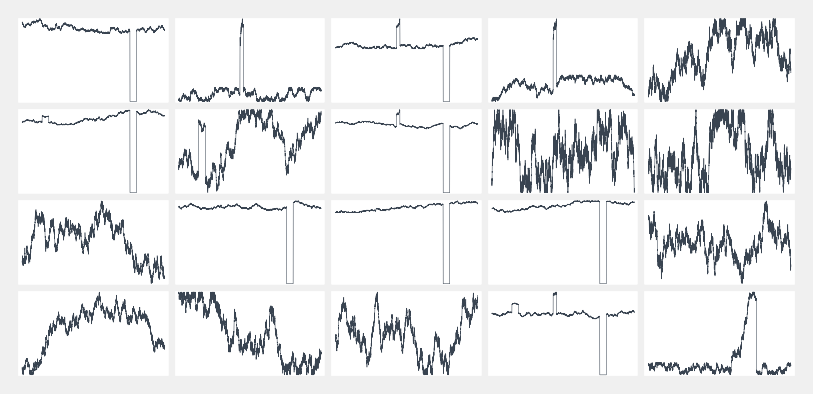

In [10]:
nrows = 4
ncols = 5
fig = plt.figure(figsize=(6,3), dpi=150)
gs = GridSpec(nrows=nrows, ncols=ncols, wspace=0.0, hspace=0.0)

index = 0
for i in range(0,nrows):
    for j in range(0,ncols):
        if index < len(tags_list):
            ax = fig.add_subplot(gs[i * ncols + j])
            current_tag = tags_list[index]
            ax.plot(all_tags_df.loc[evaluation_start:evaluation_end, current_tag], color='#232F3E', linewidth=0.25, alpha=0.9)
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax.set_facecolor("#FFFFFF")
            ax.grid(color='red', linestyle='-.', linewidth=0.7)

        index += 1

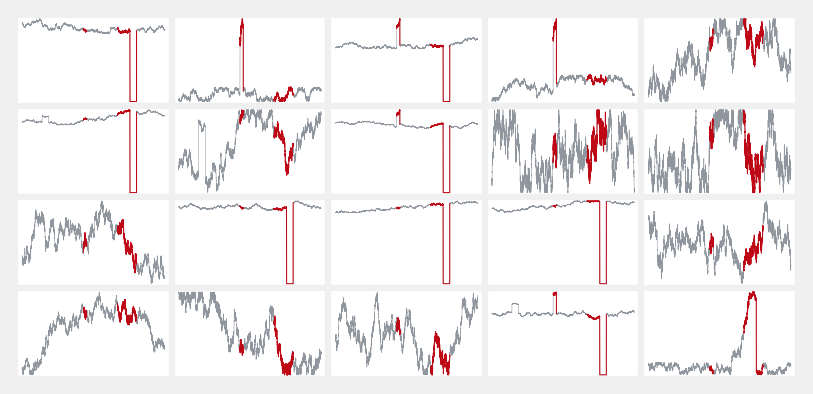

In [11]:
fig = plt.figure(figsize=(6,3), dpi=150)
gs = GridSpec(nrows=nrows, ncols=ncols, wspace=0.0, hspace=0.0)

index = 0
for i in range(0,nrows):
    for j in range(0,ncols):
        if index < len(tags_list):
            ax = fig.add_subplot(gs[i * ncols + j])
            current_tag = tags_list[index]
            current_tag_df = all_tags_df.loc[evaluation_start:evaluation_end, current_tag]
            ax.plot(current_tag_df, color='#232F3E', linewidth=0.25, alpha=0.5)
            
            for _, row in predicted_ranges.iterrows():
                event_start = row['start']
                event_end = row['end']
                ax.plot(all_tags_df.loc[event_start:event_end, current_tag], color='#bf0816', linewidth=0.5)
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax.set_facecolor("#FFFFFF")
            ax.grid(color='red', linestyle='-.', linewidth=0.7)

        index += 1

### Plotting top contributors

In [12]:
TSViz = lookout.plot.TimeSeriesVisualization(timeseries_df=all_tags_df, data_format='tabular')
TSViz.add_signal([tags_list[3]])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
predictions_df = TSViz._convert_ranges(predicted_ranges, default_freq='10min')

In [13]:
expanded_results = []
for index, row in predicted_ranges.iterrows():
    new_row = dict()
    new_row.update({'start': row['start']})
    new_row.update({'end': row['end']})
    new_row.update({'prediction': 1.0})
    
    diagnostics = pd.DataFrame(row['diagnostics'])
    diagnostics = dict(zip(diagnostics['name'], diagnostics['value']))
    new_row = {**new_row, **diagnostics}
        
    expanded_results.append(new_row)
    
expanded_results = pd.DataFrame(expanded_results)

df_list = []
for index, row in expanded_results.iterrows():
    new_index = pd.date_range(start=row['start'], end=row['end'], freq='5T')
    new_df = pd.DataFrame(index=new_index)
    
    for tag in [t for t in tags_list]:
        new_df[tag] = row[f'synthetic\\{tag}']
        
    df_list.append(new_df)
    
expanded_results = pd.concat(df_list, axis='index')
expanded_results = expanded_results.reindex(predictions_df.index)
expanded_results = expanded_results.resample('1D').mean()
expanded_results = expanded_results.replace(to_replace=np.nan, value=0.0)

In [14]:
df = expanded_results.loc[evaluation_start:evaluation_end, :].copy()
current_tags_list = list(df.sum().sort_values(ascending=False).head(4).index)

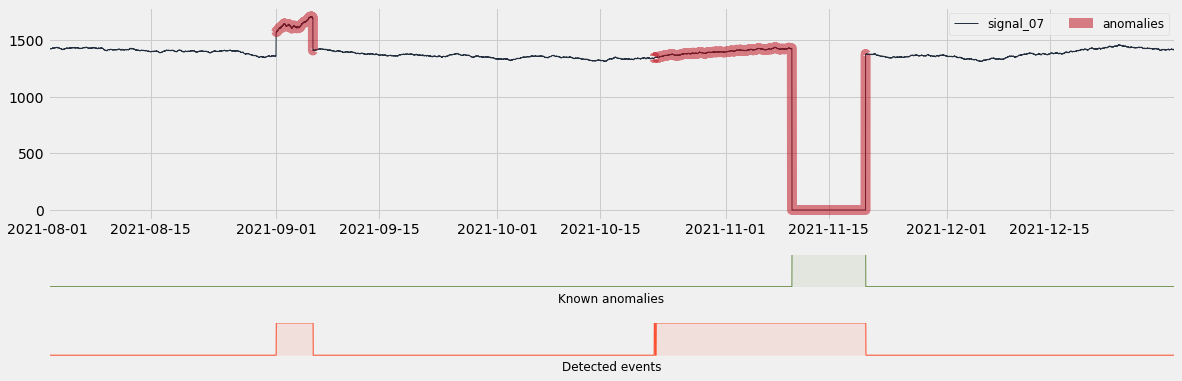

In [17]:
plot_start = pd.to_datetime('2021-08-01')
plot_end = evaluation_end
signal = 'signal_07'

fig = plt.figure(figsize=(18,6))
gs = GridSpec(nrows=3, ncols=1, height_ratios=[0.6, 0.1, 0.1], hspace=0.35)
df = expanded_results.loc[plot_start:plot_end, :].copy()

ax0 = fig.add_subplot(gs[0])
ax0.plot(all_tags_df.loc[plot_start:plot_end, signal], color='#232F3E', linewidth=1.0, label=signal)
for index, row in predicted_ranges.iterrows():
    event_start = row['start']
    event_end = row['end']
    if index == 0:
        ax0.plot(all_tags_df.loc[event_start:event_end, signal], color='#bf0816', linewidth=10.0, alpha=0.5, label='anomalies')
    else:
        ax0.plot(all_tags_df.loc[event_start:event_end, signal], color='#bf0816', linewidth=10.0, alpha=0.5)
ax0.legend(loc='upper right', ncol=2, fontsize=12)
ax0.set_xlim((plot_start, plot_end))

ax3 = fig.add_subplot(gs[1])
labels_df = TSViz._convert_ranges(labeled_range, default_freq='5min')
plot_ranges(labels_df, 'Known anomalies', colors[3], ax3)
ax3.set_xlim((plot_start, plot_end))

ax3 = fig.add_subplot(gs[2])
plot_ranges(predictions_df, 'Detected events', colors[1], ax3)
ax3.set_xlim((plot_start, plot_end))

plt.show()

## Histogram visualization
---

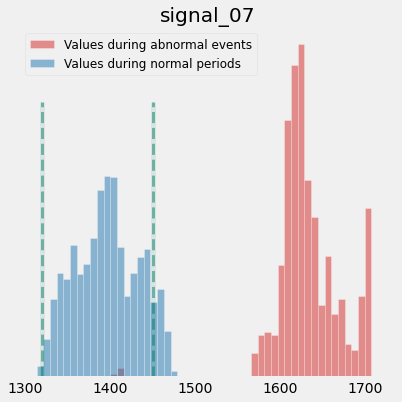

In [18]:
plot_start = pd.to_datetime(training_start)
plot_end = pd.to_datetime('2021-10-15')

fig, ax = plot_histograms('signal_07', expanded_results, freq='10min', fig_width=6, fig_height=6, start=plot_start, end=plot_end)
ax = fig.axes[0]
ax.vlines(1320, ymin=0.0, ymax=0.016, linestyle='--', linewidth=3.0, color='#067f68', alpha=0.5)
ax.vlines(1320, ymin=0.0, ymax=0.016, linewidth=5.0, color='#067f68', alpha=0.1)
ax.vlines(1450, ymin=0.0, ymax=0.016, linestyle='--', linewidth=3.0, color='#067f68', alpha=0.5)
ax.vlines(1450, ymin=0.0, ymax=0.016, linewidth=5.0, color='#067f68', alpha=0.1)
plt.show()

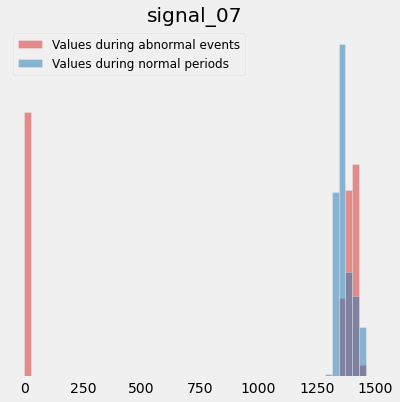

In [19]:
plot_start = pd.to_datetime('2021-09-15')
plot_end = pd.to_datetime(evaluation_end)

fig, ax = plot_histograms('signal_07', expanded_results, freq='10min', fig_width=6, fig_height=6, start=plot_start, end=plot_end)
plt.show()

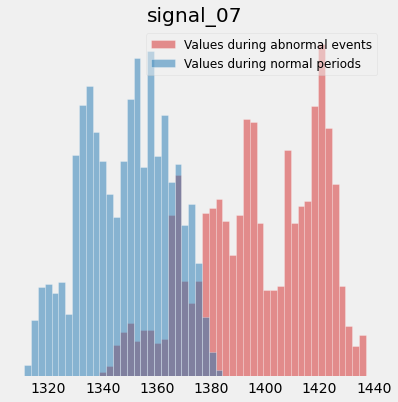

In [20]:
plot_start = pd.to_datetime('2021-09-15')
plot_end = pd.to_datetime('2021-11-09 23:59')

fig, ax = plot_histograms('signal_07', expanded_results, freq='10min', fig_width=6, fig_height=6, start=plot_start, end=plot_end)
plt.show()

## Conclusion
---
In this notebook, you extracted the raw results from the anomaly detection model you trained previously and experimented with a few post-processing techniques to get more insights from your model results.